### Importing Libraries

In [23]:
import pandas as pd


### Reading Data

In [2]:
df = pd.read_csv('../complaints.csv')
df['Date received'] = pd.to_datetime(df['Date received'])

cols_to_consider = ['Product','Sub-product','Issue','Sub-issue','Consumer complaint narrative','Company public response','Company',
                    'State', 'ZIP code', 'Date received']
df_new = df[cols_to_consider]

df_new = df_new.dropna()

### Preprocessing

In [3]:
product_map = {'Credit reporting or other personal consumer reports' : 'Credit Reporting',
               'Credit reporting, credit repair services, or other personal consumer reports' : 'Credit Reporting',
               'Payday loan, title loan, personal loan, or advance loan' : 'Loans / Mortgage',
               'Payday loan, title loan, or personal loan' : 'Loans / Mortgage',
               'Student loan' : 'Loans / Mortgage',
               'Vehicle loan or lease' : 'Loans / Mortgage',
               'Debt collection' : 'Debt collection',
               'Credit card or prepaid card' : 'Credit/Prepaid Card',
               'Credit card' : 'Credit/Prepaid Card',
               'Prepaid card' : 'Credit/Prepaid Card',
               'Mortgage' : 'Loans / Mortgage',
               'Checking or savings account' : 'Checking or savings account'  
              }

df_new.loc[:,'Product'] = df_new['Product'].map(product_map)

In [13]:
df_new.head(5)

,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Date received,complaint length
0,Credit Reporting,Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,I have been trying to dispute incorrect and/or...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,AZ,85257,2023-04-27,256
1,Credit Reporting,Credit reporting,Incorrect information on your report,Information belongs to someone else,This is my 20th endeavor to tell you that I am...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NV,89148,2023-09-28,594
2,Credit Reporting,Credit reporting,Incorrect information on your report,Account status incorrect,Make sure any accounts that were discharged in...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,TX,78666,2023-01-31,1824
3,NaN,Domestic (US) money transfer,Other transaction problem,None,Cashapp withheld and applied money sent to me ...,None,"Block, Inc.",VA,220XX,2023-06-29,340
4,Checking or savings account,Checking account,Managing an account,Problem making or receiving payments,"Chime Bank mailed a check for me using their ""...",None,Chime Financial Inc,MD,21702,2023-02-15,1044


In [4]:
df_new['complaint length'] = df_new['Consumer complaint narrative'].apply(lambda x : len(x))

In [5]:
df_new = df_new[df_new['complaint length'] > 20]

complaints_to_exclude = ['See document attached', 'See the attached documents.', 'Incorrect information on my credit report', 'incorrect information on my credit report',
'please see attached file','Please see documents Attached','Incorrect information on my credit report.', 'Please see attached file', 'see attached',
'See attached', 'SEE ATTACHED DOCUMENTS', 'See Attached', 'SEE ATTACHMENT', 'SEE ATTACHMENTS', 
'XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX']

df_new = df_new[~df_new['Consumer complaint narrative'].isin(complaints_to_exclude)]

### Plots

In [6]:
import plotly.express as px

#### Top 5 common product and issues 

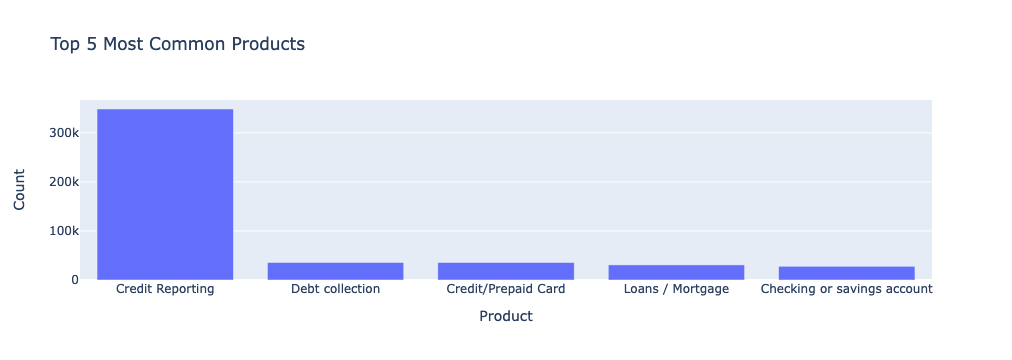

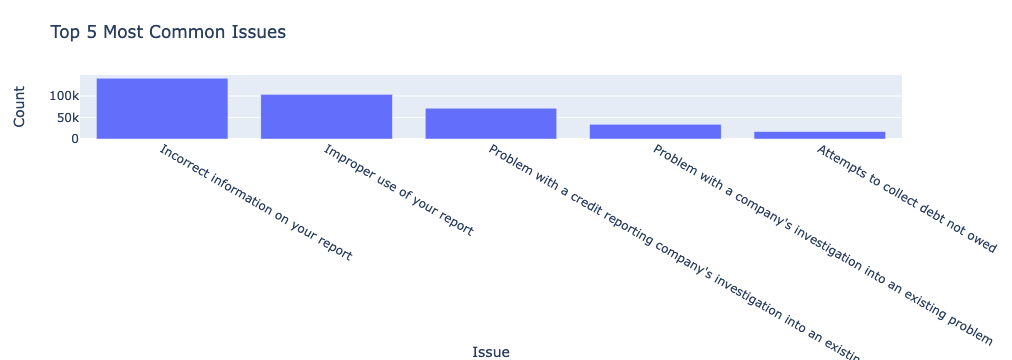

In [58]:
# Function to plot top n most common categories
def plot_top_n(df, column, title, n=5):
    counts = df[column].value_counts().reset_index()
    counts.columns = [column, 'Count']
    top_n = counts.head(n)
    fig = px.bar(top_n, x=column, y='Count', title=title)
    fig.show()

# Plotting top 5 most common products
plot_top_n(df_new, 'Product', 'Top 5 Most Common Products')

# Plotting top 5 most common issues
plot_top_n(df_new, 'Issue', 'Top 5 Most Common Issues')


#### Top 5 companies bt Number of Complaints

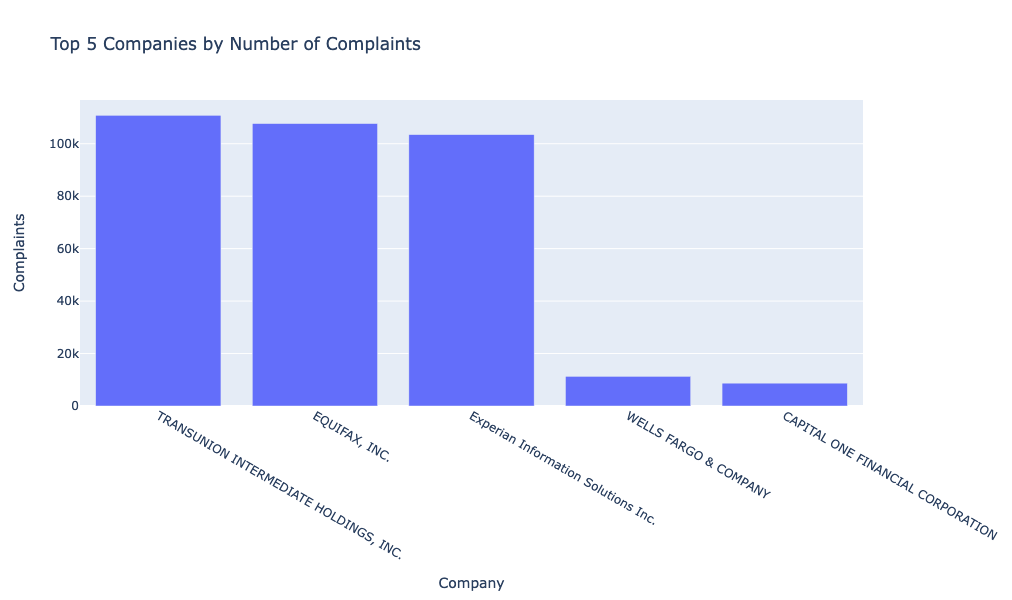

In [59]:
# Calculate the total number of complaints for each company
company_complaints = df_new['Company'].value_counts().reset_index()
company_complaints.columns = ['Company', 'Complaints']

# Sort the companies by the number of complaints and get the top 5
top_5_companies = company_complaints.sort_values(by='Complaints', ascending=False).head(5)

# Plotting the top 5 companies
fig = px.bar(top_5_companies, x='Company', y='Complaints', title='Top 5 Companies by Number of Complaints')
fig.update_layout(width=900, height=600)
fig.show()

#### Top 5 Issues in Each Product Category

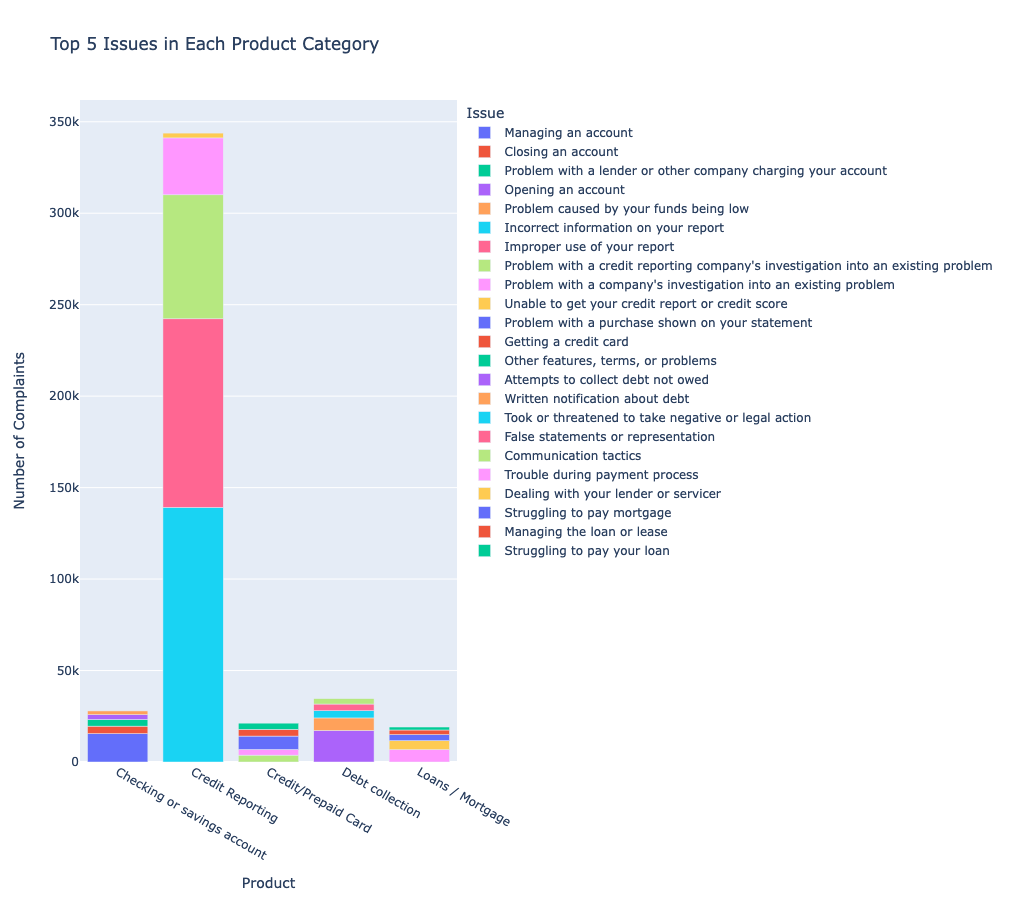

In [61]:
grouped_data = df_new.groupby(['Product', 'Issue']).size().reset_index(name='Count')

# Get top 5 issues for each product
top_issues_per_product = grouped_data.groupby('Product').apply(lambda x: x.nlargest(5, 'Count')).reset_index(drop=True)

# Create a stacked bar chart
fig = px.bar(top_issues_per_product, x='Product', y='Count', color='Issue',
             title='Top 5 Issues in Each Product Category',
             labels={'Count': 'Number of Complaints'})

fig.update_layout(width=900, height=900)

fig.show()

####  Companies with the Most Complaints in 2023

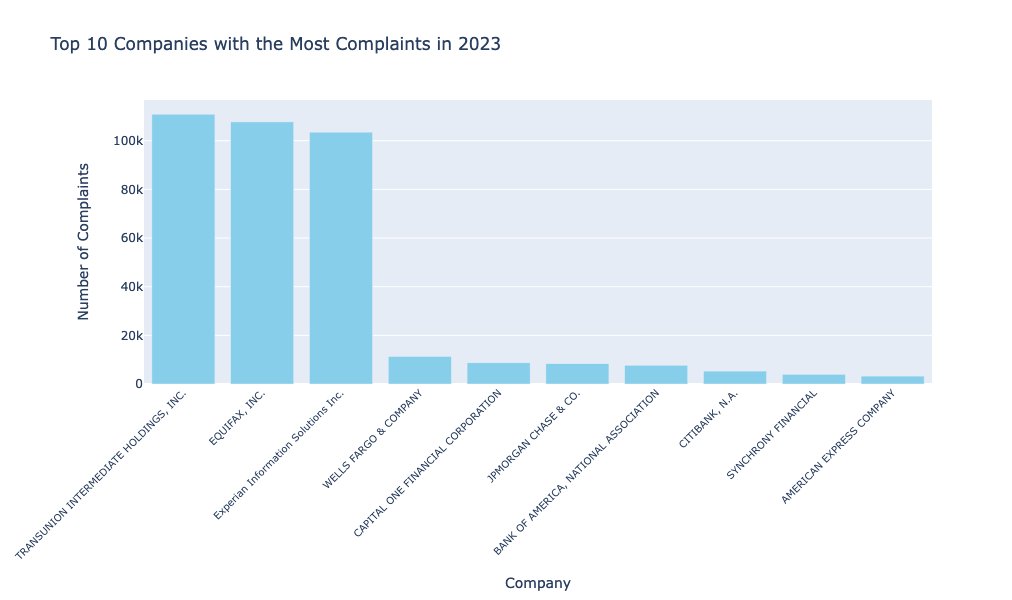

In [62]:
df_new['Date received'] = pd.to_datetime(df_new['Date received'])

# Filter data for the year 2023
df_2023 = df[df['Date received'].dt.year == 2023]

# Group data by company name and count the number of complaints for each company
company_complaint_counts = df_2023['Company'].value_counts()

top_n = 10
top_companies = company_complaint_counts.head(top_n)

fig = go.Figure(data=[go.Bar(
    x=top_companies.index,
    y=top_companies.values,
    marker_color='skyblue'
)])

fig.update_layout(
    title=f'Top {top_n} Companies with the Most Complaints in 2023',
    xaxis=dict(
        title='Company',
        tickangle=-45,
        tickfont=dict(size=10),
    ),
    yaxis=dict(
        title='Number of Complaints',
    ),
    height=600,
    width=1000,
)

fig.show()


#### Top 10 states with least complaints

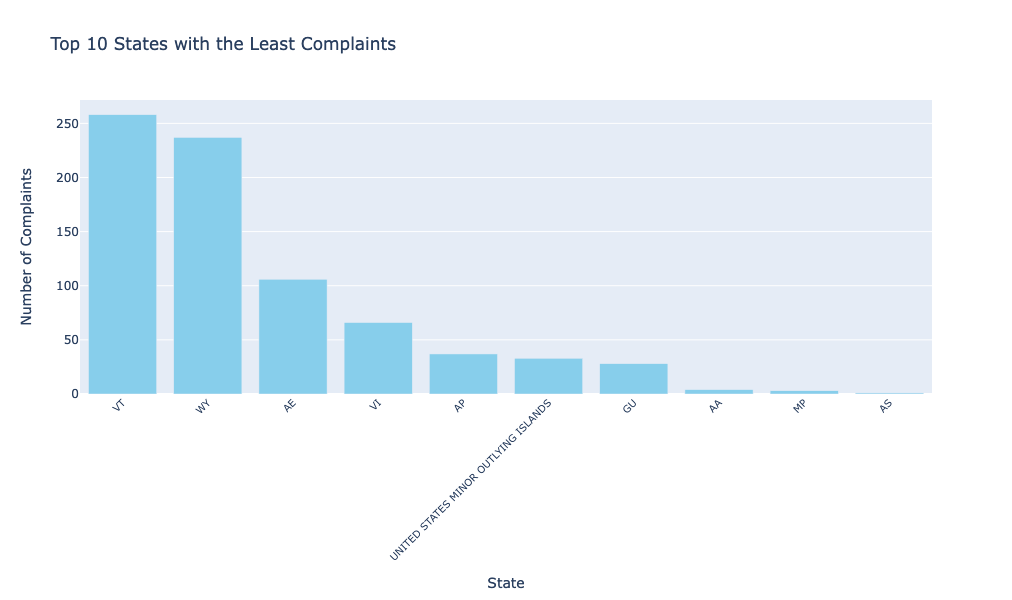

In [63]:
state_complaint_counts = df_new['State'].value_counts()

# Get top 10 states with the least complaint counts
top_n = 10
top_states = state_complaint_counts.tail(top_n)

fig = go.Figure(data=[go.Bar(
    x=top_states.index,
    y=top_states.values,
    marker_color='skyblue'
)])

fig.update_layout(
    title=f'Top {top_n} States with the Least Complaints',
    xaxis=dict(
        title='State',
        tickangle=-45,
        tickfont=dict(size=10),
    ),
    yaxis=dict(
        title='Number of Complaints',
    ),
    height=600,
    width=1000,
)

fig.show()

#### Top 10 states with the most complaint counts

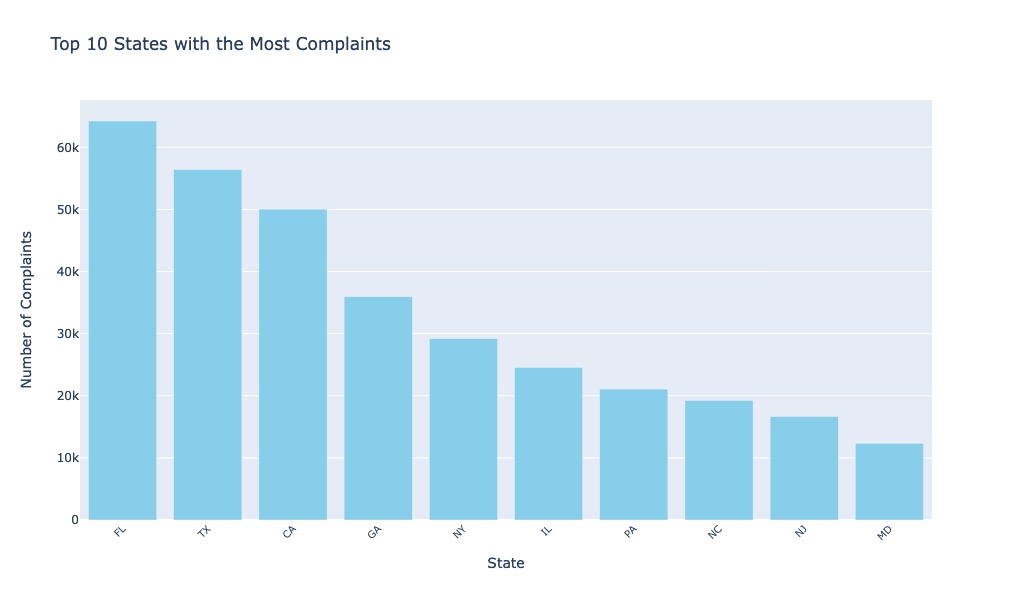

In [64]:
state_complaint_counts = df_new['State'].value_counts()

# Get top 10 states with the most complaint counts
top_n = 10
top_states = state_complaint_counts.head(top_n)


fig = go.Figure(data=[go.Bar(
    x=top_states.index,
    y=top_states.values,
    marker_color='skyblue'
)])

fig.update_layout(
    title=f'Top {top_n} States with the Most Complaints',
    xaxis=dict(
        title='State',
        tickangle=-45,
        tickfont=dict(size=10),
    ),
    yaxis=dict(
        title='Number of Complaints',
    ),
    height=600,
    width=1000,
)

fig.show()